## MoMo-Mood PHQ9 survival analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lifelines

In [2]:
phq_data = pd.read_csv("/m/cs/scratch/networks-nima-mmm2018/Arsi/Data/PHQ9_scores.csv", index_col=0)
phq_data = phq_data[["group", "user", "idx", "PHQ9"]]

In [3]:
# Filter out rows where PHQ9 is NaN
filtered_df = phq_data.dropna(subset=["PHQ9"])

In [4]:
# Group by 'group' and 'idx' to get the count of unique users at each timepoint
user_counts = filtered_df.groupby(['group', 'idx'])['user'].nunique().reset_index(name='user_count')

# Get the initial user count for each group
initial_user_counts = filtered_df.groupby('group')['user'].nunique().reset_index(name='initial_user_count')

# Merge the initial user counts with the user counts at each timepoint
merged = pd.merge(user_counts, initial_user_counts, on='group')

# Calculate the percentage of users still providing data at each timepoint
merged['percentage_remaining'] = (merged['user_count'] / merged['initial_user_count']) * 100

# Pivot the table to get the desired format
res_piv = merged.pivot(index='idx', columns='group', values='percentage_remaining').fillna(0)

In [5]:
df = filtered_df

In [6]:
# Group by 'group' and 'idx' to get the count of unique users at each timepoint
user_counts = df.groupby(['group', 'idx'])['user'].nunique().reset_index(name='user_count')

# Get the initial user count for each group
initial_user_counts = df.groupby('group')['user'].nunique().reset_index(name='initial_user_count')

# Merge the initial user counts with the user counts at each timepoint
merged = pd.merge(user_counts, initial_user_counts, on='group')

# Calculate the percentage of users still providing data at each timepoint
merged['percentage_remaining'] = (merged['user_count'] / merged['initial_user_count']) * 100

# Pivot the table to get the desired format
result = merged.pivot(index='idx', columns='group', values='percentage_remaining').fillna(0)

# Calculate total initial user count
total_initial_users = df['user'].nunique()

# Calculate the total user count at each timepoint across all groups
total_users_at_each_timepoint = df.groupby('idx')['user'].nunique()

# Calculate the overall percentage of users remaining at each timepoint
total_percentage_remaining = (total_users_at_each_timepoint / total_initial_users) * 100

# Add the total percentage remaining as a new column to the result DataFrame
result['total'] = total_percentage_remaining

# Display the result
#import ace_tools as tools; tools.display_dataframe_to_user(name="User Data Retention Table with Total", dataframe=result)

# Optionally, print the DataFrame to check
#print(result)

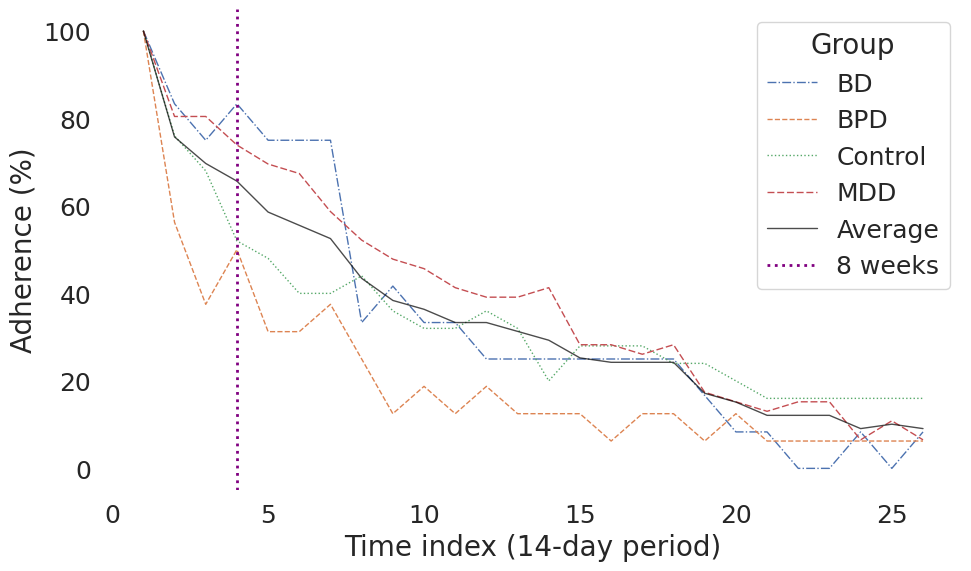

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style to remove grid and set the background to white
sns.set(style="white")

# Replace inf and -inf with NaN in the dataframe
result.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Set font sizes
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

# Use Seaborn lineplot with different line styles
sns.lineplot(data=result, x=result.index, y='bd', label='BD', linestyle='-.', linewidth=1)
sns.lineplot(data=result, x=result.index, y='bpd', label='BPD', linestyle='--', linewidth=1)
sns.lineplot(data=result, x=result.index, y='control', label='Control', linestyle=':', linewidth=1)
sns.lineplot(data=result, x=result.index, y='mdd', label='MDD', linestyle=(0, (5, 2)), linewidth=1)
sns.lineplot(data=result, x=result.index, y='total', label='Average', linestyle='-', color='black', linewidth=1, alpha=0.7)

# Removing all margins and axis spines
sns.despine(left=True, bottom=True)

# Adding a vertical line at index 4
plt.axvline(x=4, color='purple', linestyle=':', linewidth=2, label='8 weeks')

# Removing grid
plt.grid(False)

# Adding labels and title
plt.xlabel('Time index (14-day period)', fontsize=20)
plt.ylabel('Adherence (%)', fontsize=20)
#plt.title('Study adherence over time by group', fontsize=18)

# Adding legend with larger title font
legend = plt.legend(title='Group')
plt.setp(legend.get_title(), fontsize=20)  # Set font size of the legend title

# Save the plot as an image
plt.savefig("PHQ9_adherence.png")
plt.tight_layout()
# Show the plot
plt.show()


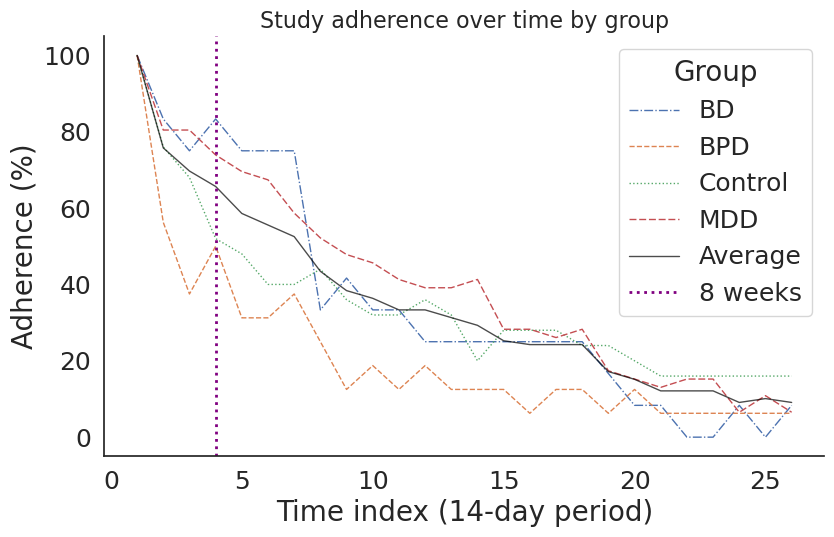

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style to remove grid and set the background to white
sns.set(style="white")

# Replace inf and -inf with NaN in the dataframe
result.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Set font sizes
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

# Use Seaborn lineplot with different line styles
sns.lineplot(data=result, x=result.index, y='bd', label='BD', linestyle='-.', linewidth=1)
sns.lineplot(data=result, x=result.index, y='bpd', label='BPD', linestyle='--', linewidth=1)
sns.lineplot(data=result, x=result.index, y='control', label='Control', linestyle=':', linewidth=1)
sns.lineplot(data=result, x=result.index, y='mdd', label='MDD', linestyle=(0, (5, 2)), linewidth=1)
sns.lineplot(data=result, x=result.index, y='total', label='Average', linestyle='-', color='black', linewidth=1, alpha=0.7)

# Removing axis spines
sns.despine(top=True, right=True)

# Adding a vertical line at index 4
plt.axvline(x=4, color='purple', linestyle=':', linewidth=2, label='8 weeks')

# Removing grid
plt.grid(False)

# Adding labels and title
plt.xlabel('Time index (14-day period)', fontsize=20)
plt.ylabel('Adherence (%)', fontsize=20)
plt.title('Study adherence over time by group',fontsize=16)

# Adding legend with larger title font
legend = plt.legend(title='Group')
plt.setp(legend.get_title(), fontsize=20)  # Set font size of the legend title

# Add extra bottom and left margins
plt.subplots_adjust(left=0.18, bottom=0.18)

# Save the plot as an image
plt.savefig("PHQ9_adherence.png", dpi=300)

# Show the plot
plt.show()


In [9]:
res_piv = merged.pivot(index='idx', columns='group', values='percentage_remaining').fillna(0)

In [10]:
# Filter out rows where PHQ9 is NaN
filtered_df = phq_data.dropna(subset=["PHQ9"])

# Group by 'user' and find the maximum 'idx' for each user
max_idx_per_user = filtered_df.groupby("user")["idx"].max()

# max_idx_per_user now contains the maximum index for each user

# Merge with the original DataFrame to get the 'group' column
merged_df = pd.merge(max_idx_per_user, phq_data, on=["user", "idx"], how="left")

# Drop duplicates to retain only the unique combination for each user
final_df = merged_df.drop_duplicates(subset=["user"])

In [11]:
# Add a new column 'event_occurred' based on the 'idx' column
final_df["event_occurred"] = final_df["idx"].apply(lambda x: 1 if x < 26 else 0)
final_df.rename(columns={"idx": "time_to_event"}, inplace=True)

---

In [12]:
# Assuming your DataFrame is named 'df'
# df.columns = ['user', 'time_to_event', 'group', 'event_occurred']

# Create an empty DataFrame to store the results
results = pd.DataFrame()

# Get the unique time points
time_points = final_df['time_to_event'].unique()
time_points.sort()

# Get the unique groups
groups = final_df['group'].unique()

# Initialize a dictionary to hold the survival percentages
survival_dict = {group: [] for group in groups}

# Calculate the percentage of remaining users for each group at each time point
for time in time_points:
    for group in groups:
        total_users = final_df[final_df['group'] == group]['user'].nunique()
        remaining_users = final_df[(final_df['group'] == group) & (final_df['time_to_event'] >= time)]['user'].nunique()
        survival_percentage = (remaining_users / total_users) * 100
        survival_dict[group].append(survival_percentage)

# Convert the dictionary to a DataFrame
survival_df = pd.DataFrame(survival_dict, index=time_points)

# Set the index name
survival_df.index.name = 'time_to_event'

# Display the results
!import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table", dataframe=survival_df)

# Optionally, you can print the DataFrame to check
#print(survival_df)


/bin/bash: -c: line 1: syntax error near unexpected token `name="Survival Analysis Table",'
/bin/bash: -c: line 1: `import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table", dataframe=survival_df)'


In [13]:
import pandas as pd

# Assuming your DataFrame is named 'final_df'
# final_df.columns = ['user', 'time_to_event', 'group', 'event_occurred']

# Create an empty DataFrame to store the results
results = pd.DataFrame()

# Get the unique time points and create a complete range
time_points = final_df['time_to_event'].unique()
time_points.sort()
complete_time_points = pd.RangeIndex(start=time_points.min(), stop=time_points.max() + 1, step=1)

# Get the unique groups
groups = final_df['group'].unique()

# Initialize a dictionary to hold the survival percentages
survival_dict = {group: [] for group in groups}
total_survival = []

# Calculate the percentage of remaining users for each group at each time point
for time in complete_time_points:
    total_users_all_groups = 0
    total_remaining_all_groups = 0
    for group in groups:
        total_users = final_df[final_df['group'] == group]['user'].nunique()
        remaining_users = final_df[(final_df['group'] == group) & (final_df['time_to_event'] >= time)]['user'].nunique()
        survival_percentage = (remaining_users / total_users) * 100
        survival_dict[group].append(survival_percentage)
        total_users_all_groups += total_users
        total_remaining_all_groups += remaining_users
    
    # Calculate the pooled survival percentage across all groups
    pooled_survival_percentage = (total_remaining_all_groups / total_users_all_groups) * 100
    total_survival.append(pooled_survival_percentage)

# Convert the dictionary to a DataFrame
survival_df = pd.DataFrame(survival_dict, index=complete_time_points)

# Add the pooled survival percentage column
survival_df['total_survival_percentage'] = total_survival

# Fill missing values using linear interpolation for each column
survival_df = survival_df.interpolate(method='linear')

# Set the index name
survival_df.index.name = 'time_to_event'

# Save to CSV (if needed)
csv_file_path = './survival_analysis.csv'
survival_df.to_csv(csv_file_path)

# Display the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table", dataframe=survival_df)

# Optionally, you can print the DataFrame to check
print(survival_df)



               control     bpd         mdd          bd  \
time_to_event                                            
1                100.0  100.00  100.000000  100.000000   
2                 80.0   62.50   91.304348  100.000000   
3                 68.0   56.25   89.130435  100.000000   
4                 52.0   50.00   86.956522  100.000000   
5                 48.0   37.50   80.434783  100.000000   
6                 44.0   37.50   73.913043   91.666667   
7                 44.0   37.50   65.217391   83.333333   
8                 44.0   25.00   58.695652   50.000000   
9                 40.0   25.00   56.521739   41.666667   
10                36.0   25.00   54.347826   33.333333   
11                36.0   18.75   52.173913   33.333333   
12                36.0   18.75   52.173913   33.333333   
13                32.0   12.50   50.000000   33.333333   
14                28.0   12.50   47.826087   33.333333   
15                28.0   12.50   36.956522   33.333333   
16            

In [14]:
df = final_df

In [15]:
import pandas as pd

# Assuming your DataFrame is named 'final_df'
# final_df.columns = ['user', 'time_to_event', 'group', 'event_occurred']

# Create an empty DataFrame to store the results
results = pd.DataFrame()

# Get the unique time points and create a complete range
time_points = final_df['time_to_event'].unique()
time_points.sort()
complete_time_points = pd.RangeIndex(start=time_points.min(), stop=time_points.max() + 1, step=1)

# Get the unique groups
groups = final_df['group'].unique()

# Initialize a dictionary to hold the survival percentages
survival_dict = {group: [] for group in groups}

# Calculate the percentage of remaining users for each group at each time point
for group in groups:
    group_survival = []
    for time in complete_time_points:
        total_users = final_df[final_df['group'] == group]['user'].nunique()
        remaining_users = final_df[(final_df['group'] == group) & (final_df['time_to_event'] >= time)]['user'].nunique()
        survival_percentage = (remaining_users / total_users) * 100
        group_survival.append(survival_percentage)
    survival_dict[group] = group_survival

# Convert the dictionary to a DataFrame
survival_df = pd.DataFrame(survival_dict, index=complete_time_points)

# Fill missing values using forward fill for each column
survival_df = survival_df.ffill()

# Set the index name
survival_df.index.name = 'time_to_event'

# Save to CSV (if needed)
csv_file_path = './survival_analysis.csv'
survival_df.to_csv(csv_file_path)

# Display the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table", dataframe=survival_df)

# Optionally, you can print the DataFrame to check
print(survival_df)




               control     bpd         mdd          bd
time_to_event                                         
1                100.0  100.00  100.000000  100.000000
2                 80.0   62.50   91.304348  100.000000
3                 68.0   56.25   89.130435  100.000000
4                 52.0   50.00   86.956522  100.000000
5                 48.0   37.50   80.434783  100.000000
6                 44.0   37.50   73.913043   91.666667
7                 44.0   37.50   65.217391   83.333333
8                 44.0   25.00   58.695652   50.000000
9                 40.0   25.00   56.521739   41.666667
10                36.0   25.00   54.347826   33.333333
11                36.0   18.75   52.173913   33.333333
12                36.0   18.75   52.173913   33.333333
13                32.0   12.50   50.000000   33.333333
14                28.0   12.50   47.826087   33.333333
15                28.0   12.50   36.956522   33.333333
16                28.0   12.50   34.782609   33.333333
17        

In [16]:
# Set the index name
#survival_df.set_index('time_to_event', inplace=True)
survival_df = result
# Format the DataFrame to one decimal place
survival_df = survival_df.applymap(lambda x: f"{x:.1f}")

# Save to CSV
csv_file_path = './survival_analysis.csv'
survival_df.to_csv(csv_file_path)

# Display the results
!import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table (Formatted)", dataframe=survival_df)

# Optionally, you can print the DataFrame to check
print(survival_df)

/bin/bash: -c: line 1: syntax error near unexpected token `name="Survival Analysis Table (Formatted)",'
/bin/bash: -c: line 1: `import ace_tools as tools; tools.display_dataframe_to_user(name="Survival Analysis Table (Formatted)", dataframe=survival_df)'
group     bd    bpd control    mdd  total
idx                                      
1      100.0  100.0   100.0  100.0  100.0
2       83.3   56.2    76.0   80.4   75.8
3       75.0   37.5    68.0   80.4   69.7
4       83.3   50.0    52.0   73.9   65.7
5       75.0   31.2    48.0   69.6   58.6
6       75.0   31.2    40.0   67.4   55.6
7       75.0   37.5    40.0   58.7   52.5
8       33.3   25.0    44.0   52.2   43.4
9       41.7   12.5    36.0   47.8   38.4
10      33.3   18.8    32.0   45.7   36.4
11      33.3   12.5    32.0   41.3   33.3
12      25.0   18.8    36.0   39.1   33.3
13      25.0   12.5    32.0   39.1   31.3
14      25.0   12.5    20.0   41.3   29.3
15      25.0   12.5    28.0   28.3   25.3
16      25.0    6.2    28.0   2

/tmp/ipykernel_3819487/2117273191.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  survival_df = survival_df.applymap(lambda x: f"{x:.1f}")


In [17]:
# Save to CSV
csv_file_path = './survival_analysis.csv'
survival_df.to_csv(csv_file_path)

---

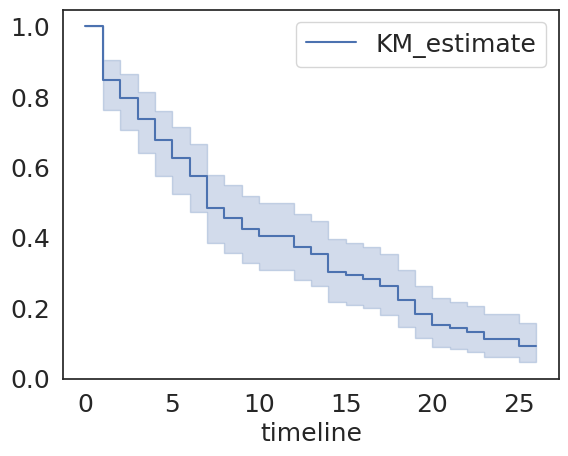

In [18]:
from lifelines import KaplanMeierFitter

# Create an instance of the KaplanMeierFitter class
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=final_df["time_to_event"], event_observed=final_df["event_occurred"])

# Plot the survival function
kmf.plot_survival_function()

# Display the plot
plt.show()

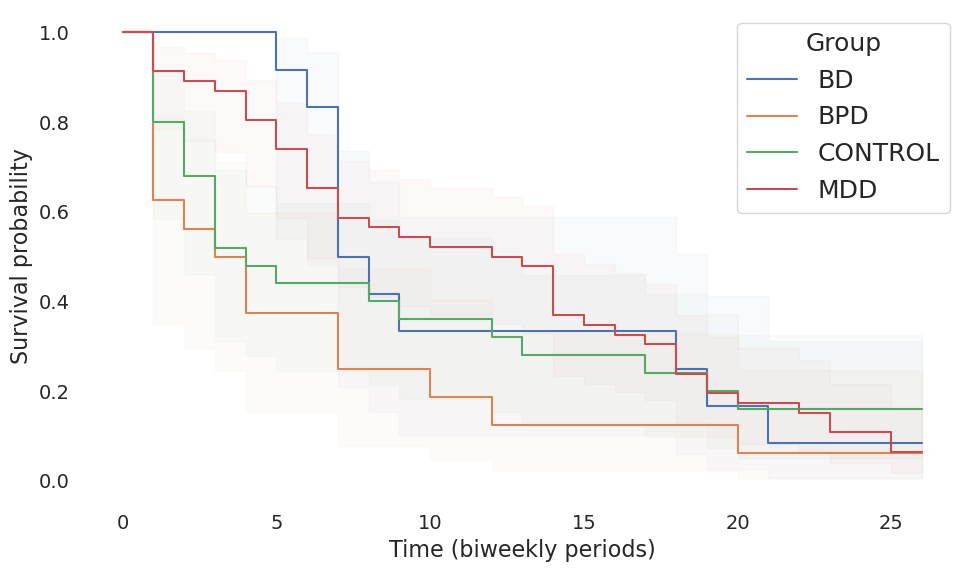

In [19]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

# Set font sizes for the plot
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each group in alphabetical order
for group in sorted(final_df["group"].unique()):  # Sort the groups alphabetically
    # Subset to the group
    group_df = final_df[final_df["group"] == group]

    # Fit the model for this group
    kmf.fit(
        durations=group_df["time_to_event"],
        event_observed=group_df["event_occurred"],
        label=str(group).upper(),  # Convert the group name to uppercase
    )

    # Plot the survival function for this group with confidence intervals
    kmf.plot_survival_function(ax=ax, ci_show=True, ci_alpha=0.03)

# Remove borders, ticks, and spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)  # Remove ticks

# Optionally, remove the grid as well
ax.grid(False)

# Add title and labels
plt.xlabel("Time (biweekly periods)")
plt.ylabel("Survival probability")

# Adjust layout to make it tighter
plt.tight_layout()  # Reduce padding between elements

# Customize the legend
legend = ax.legend(title='Group', title_fontsize=18)  # Match the title font size to the labels

# Save the plot as an image file
plt.savefig('PHQ9_survival.svg')



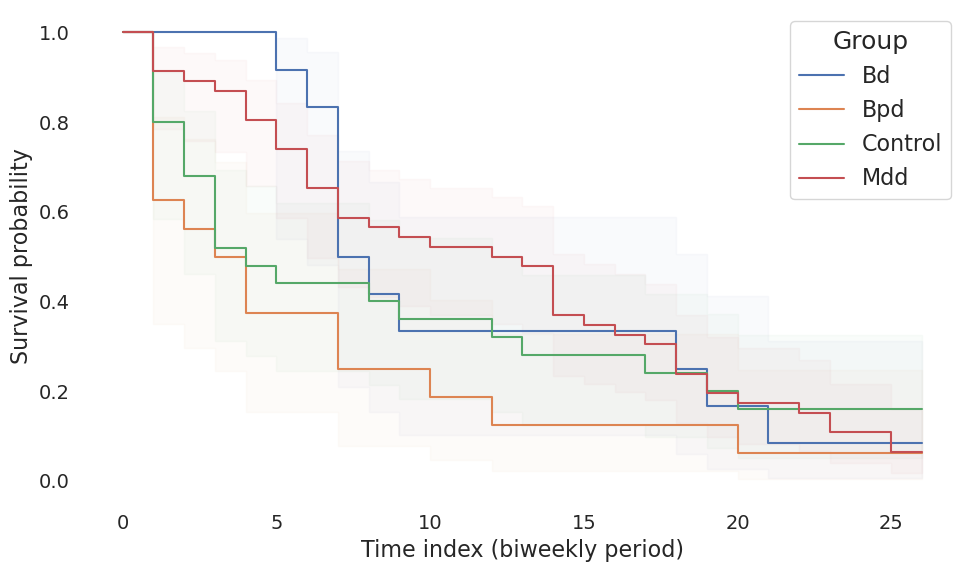

In [20]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

# Set font sizes for the plot
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))

# Group renaming (mapping CONTROL -> Control)
group_mapping = {"CONTROL": "Control"}

# Iterate over each group in alphabetical order
for group in sorted(final_df["group"].unique()):  # Sort the groups alphabetically
    # Subset to the group
    group_df = final_df[final_df["group"] == group]
    
    # Apply the group mapping to rename the group if necessary
    group_name = group_mapping.get(group, group)  # Default to the original name if not mapped

    # Fit the model for this group
    kmf.fit(
        durations=group_df["time_to_event"],
        event_observed=group_df["event_occurred"],
        label=str(group_name).capitalize(),  # Ensure proper capitalization
    )

    # Plot the survival function for this group with confidence intervals
    kmf.plot_survival_function(ax=ax, ci_show=True, ci_alpha=0.03)

# Remove borders, ticks, and spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)  # Remove ticks

# Optionally, remove the grid as well
ax.grid(False)

# Add title and labels
plt.xlabel("Time index (biweekly period)")
plt.ylabel("Survival probability")

# Adjust layout to make it tighter
plt.tight_layout()  # Reduce padding between elements

# Customize the legend
legend = ax.legend(title='Group')
plt.setp(legend.get_title(), fontsize=18)  # Set font size of the legend title

# Save the plot as an image file
plt.savefig('PHQ9_survival.png')


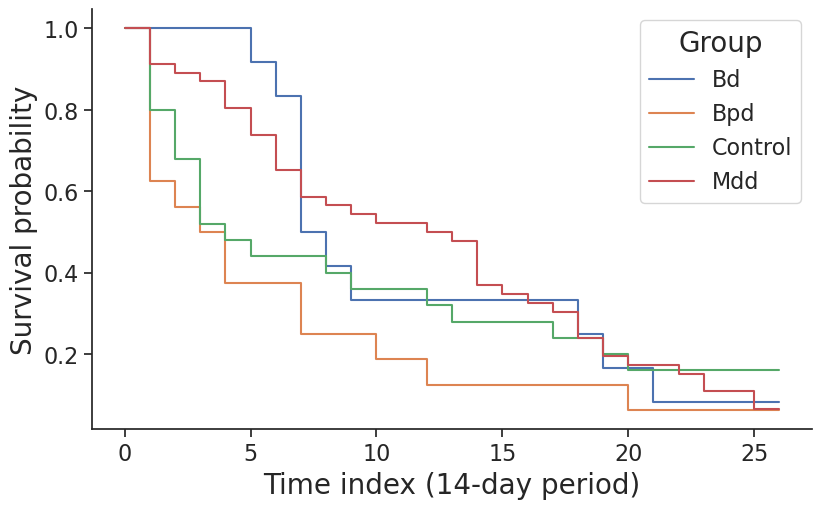

In [21]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

# Set font sizes for the plot (comparable with previous plots)
plt.rc('font', size=16)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=20)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))

# Group renaming (mapping CONTROL -> Control)
group_mapping = {"CONTROL": "Control"}

# Iterate over each group in alphabetical order
for group in sorted(final_df["group"].unique()):  
    group_df = final_df[final_df["group"] == group]
    group_name = group_mapping.get(group, group)

    # Fit the model
    kmf.fit(
        durations=group_df["time_to_event"],
        event_observed=group_df["event_occurred"],
        label=str(group_name).capitalize(),
    )

    # Plot survival function (no shading)
    kmf.plot_survival_function(ax=ax, ci_show=False)

# Keep only left & bottom spines (like your other plots)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=True, bottom=True)

# Remove grid
ax.grid(False)

# Labels
plt.xlabel("Time index (14-day period)", fontsize=20)
plt.ylabel("Survival probability", fontsize=20)

# Legend with title
legend = ax.legend(title='Group')
plt.setp(legend.get_title(), fontsize=20)

# Adjust margins
plt.subplots_adjust(left=0.18, bottom=0.18)

# Save figure
plt.savefig('PHQ9_survival.png', dpi=300)

plt.show()


---

In [22]:
## Log-rank test

In [23]:
from lifelines.statistics import multivariate_logrank_test

# Perform the log-rank test
results = multivariate_logrank_test(
    event_durations=final_df["time_to_event"],
    event_observed=final_df["event_occurred"],
    groups=final_df["group"],
)

# Print the test results
print(results.summary)

   test_statistic         p  -log2(p)
0        4.599751  0.203563   2.29645


In [24]:
import itertools
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests

group_pairs = list(itertools.combinations(final_df["group"].unique(), 2))
comparison_results = []

for group1, group2 in group_pairs:
    data_group1 = final_df[final_df["group"] == group1]
    data_group2 = final_df[final_df["group"] == group2]

    result = logrank_test(
        data_group1["time_to_event"],
        data_group2["time_to_event"],
        event_observed_A=data_group1["event_occurred"],
        event_observed_B=data_group2["event_occurred"],
    )

    comparison_results.append(
        {"group_1": group1, "group_2": group2, "p-val": result.p_value}
    )

In [25]:
# Extract the original p-values
p_values = [result["p-val"] for result in comparison_results]

# Apply Benjamini-Hochberg FDR correction
p_adjusted = multipletests(p_values, alpha=0.05, method="fdr_bh")[1]

# Update the list with adjusted p-values
for result, adj_p in zip(comparison_results, p_adjusted):
    result["adjusted p-val"] = adj_p

In [26]:
# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(comparison_results)

# Display the DataFrame
print(results_df)

   group_1 group_2     p-val  adjusted p-val
0  control     bpd  0.273597        0.547194
1  control     mdd  0.605462        0.728505
2  control      bd  0.607088        0.728505
3      bpd     mdd  0.031532        0.189193
4      bpd      bd  0.121748        0.365245
5      mdd      bd  0.996095        0.996095
